Based on this article: https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cross_validation as cv
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt

/Users/chenyingcharlene/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
reviews_df = pd.read_json("../../dataset/review_10k.json", lines=True)

In [3]:
# This cell creates a unique integer per business_id and a unique integer per user_id. 
# It then maps the business_id and user_id into business_id_int and user_id_int in the reviews_df.
# This is so that when we work with user-business matrices, we are dealing with integers as indexes rather than strings.

# Create an integer-based user-id
uid_map = {}
c = 0
for uid in reviews_df.user_id.unique():
    uid_map[uid] = c
    c += 1

# Create an integer-based business-id
bid_map = {}
c = 0
for bid in reviews_df.business_id.unique():
    bid_map[bid] = c
    c += 1
    
reviews_df['user_id_int'] = reviews_df.user_id.apply(lambda x: uid_map[x])
reviews_df['business_id_int'] = reviews_df.business_id.apply(lambda x: bid_map[x])

In [4]:
reviews_df.head(10)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,user_id_int,business_id_int
0,0W4lkclzZThpx3V65bVgig,0,2016-05-28,0,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0,bv2nCi5Qv5vroFiqKGopiw,0,0
1,AEx2SYEUJmTxVVB18LlCwA,0,2016-05-28,0,vkVSCC7xljjrAI4UGfnKEQ,5,Super simple place but amazing nonetheless. It...,0,bv2nCi5Qv5vroFiqKGopiw,0,1
2,VR6GpWIda3SfvPC-lg9H3w,0,2016-05-28,0,n6QzIUObkYshz4dz2QRJTw,5,Small unassuming place that changes their menu...,0,bv2nCi5Qv5vroFiqKGopiw,0,2
3,CKC0-MOWMqoeWf6s-szl8g,0,2016-05-28,0,MV3CcKScW05u5LVfF6ok0g,5,Lester's is located in a beautiful neighborhoo...,0,bv2nCi5Qv5vroFiqKGopiw,0,3
4,ACFtxLv8pGrrxMm6EgjreA,0,2016-05-28,0,IXvOzsEMYtiJI0CARmj77Q,4,Love coming here. Yes the place always needs t...,0,bv2nCi5Qv5vroFiqKGopiw,0,4
5,s2I_Ni76bjJNK9yG60iD-Q,0,2016-05-28,0,L_9BTb55X0GDtThi6GlZ6w,4,Had their chocolate almond croissant and it wa...,0,bv2nCi5Qv5vroFiqKGopiw,0,5
6,8QWPlVQ6D-OExqXoaD2Z1g,0,2014-09-24,0,HRPm3vEZ_F-33TYVT7Pebw,5,Cycle Pub Las Vegas was a blast! Got a groupon...,1,_4iMDXbXZ1p1ONG297YEAQ,1,6
7,9_CGhHMz8698M9-PkVf0CQ,2,2012-05-11,0,ymAUG8DZfQcFTBSOiaNN4w,4,Who would have guess that you would be able to...,0,u0LXt3Uea_GidxRW1xcsfg,2,7
8,gkCorLgPyQLsptTHalL61g,0,2015-10-27,0,8UIishPUD92hXtScSga_gw,4,Always drove past this coffee house and wonder...,1,u0LXt3Uea_GidxRW1xcsfg,2,8
9,5r6-G9C4YLbC7Ziz57l3rQ,0,2013-02-09,0,w41ZS9shepfO3uEyhXEWuQ,3,"Not bad!! Love that there is a gluten-free, ve...",1,u0LXt3Uea_GidxRW1xcsfg,2,9


In [6]:
df = reviews_df[['user_id_int', 'business_id_int', 'stars']]
n_users = df.user_id_int.unique().shape[0]
n_businesses = df.business_id_int.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of businesses = ' + str(n_businesses))

Number of users = 1059 | Number of businesses = 8261


In [7]:
# Split train and test data
train_data, test_data = cv.train_test_split(df, test_size=0.25)

In [8]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_businesses))
for line in train_data.itertuples():
    train_data_matrix[line[1], line[2]] = line[3]

test_data_matrix = np.zeros((n_users, n_businesses))
for line in test_data.itertuples():
    test_data_matrix[line[1], line[2]] = line[3]

In [17]:
np.zeros((2, 3))

array([[0., 0., 0.],
       [0., 0., 0.]])

In [15]:
train_data_matrix[:4]

array([[5., 5., 5., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [35]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [36]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

In [37]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [38]:
print ('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print ('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.9221491627474765
Item-based CF RMSE: 3.920440569052363


Issue:
1) prediction matrix not in the range of 0-5
2) binary outcome to align with the other model? (accuracy and f1 score.)
3) Do we use RSME as one metrics? LDA doesn't have that one

Achieve:
1) error analysis dataframe for worst examples 
2) confusion matrix


In [139]:
# it seems that the user_prediction matrix is not in the range of 1-5 (0 if n value). - Charlene
print ('Range of user_prediction:', round(np.ptp(user_prediction),3))
print ('Range of user_prediction_round:', np.ptp(user_prediction_round))
print ('Range of test_data_matrix:', np.ptp(test_data_matrix))

Range of user_prediction: 0.123
Range of user_prediction_round: 0.0
Range of test_data_matrix: 5.0


In [39]:
# I think prediction of star rating is intiger as well - Charlene
def predict_round(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return np.around(pred)

item_prediction_round = predict_round(train_data_matrix, item_similarity, type='item')
user_prediction_round = predict_round(train_data_matrix, user_similarity, type='user')

print ('User-based Rounded CF RMSE: ' + str(rmse(user_prediction_round, test_data_matrix)))
print ('Item-based Rounded CF RMSE: ' + str(rmse(item_prediction_round, test_data_matrix)))

User-based Rounded CF RMSE: 3.947100201413691
Item-based Rounded CF RMSE: 3.947100201413691


In [208]:
# generate binary recommendation for accuracy and f1 score.

from sklearn.metrics import f1_score

test_data_matrix_list = list(test_data_matrix[test_data_matrix.nonzero()].flatten())

user_prediction_round_list = list(user_prediction_round[test_data_matrix.nonzero()].flatten())
item_prediction_round_list = list(item_prediction_round[test_data_matrix.nonzero()].flatten())

user_prediction_reco = list()


for i in len(user_prediction_round_list):
    if user_prediction_round_list[i] >=4:
        user_prediction_reco[i] = 1
    else user_prediction_reco[i] = 0
    if item_prediction_round_list[i] >=4:
        item_prediction_reco[i] = 1
    else item_prediction_reco[i] = 0
    if test_data_matrix_list[i] >=4:
        test_reco[i] = 1
    else test_reco[i] = 0

print ('User-based Rounded F1 score: ' + f1_score(test_reco, user_prediction_reco))
print ('Item-based Rounded F1 score: ' + f1_score(test_reco, item_prediction_reco))

SyntaxError: invalid syntax (<ipython-input-208-7074ab0be9d9>, line 14)

# Error Aalysis

In [49]:
diff_rating_matrix = np.subtract(user_prediction_round, test_data_matrix)
diff_rating_matrix

array([[ 0.,  0., -0., ...,  0.,  0., -0.],
       [ 0.,  0.,  0., ..., -0.,  0., -0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0., -0.],
       [ 0.,  0.,  0., ..., -0.,  0., -0.],
       [ 0.,  0.,  0., ..., -0., -0., -3.]])

In [50]:
# Does this make sense? Sum of rating error is so neative?
np.sum(diff_rating_matrix)

-9341.0

In [47]:
np.argmax(np.absolute(diff_rating_matrix))

41396

In [48]:
np.unravel_index(diff_rating_matrix.argmax(), diff_rating_matrix.shape)

(0, 0)

In [82]:
# Extra the biggest error, which is the rating difference >=5 or 4?
# since our prediction of rating can be 0, does that make sense?
indices = np.where(np.absolute(diff_rating_matrix) >= 5)

user_id_int_x = indices[0]
business_id_int_y = indices[1]
pred_value = user_prediction_round[list(user_id_int_x),list(business_id_int_y)]
starts_value = test_data_matrix[list(user_id_int_x),list(business_id_int_y)]

In [140]:
error_analysis_df = pd.DataFrame(columns=['business_id','user_id','date','text','pred','stars'])
error_analysis_df['user_id'] = list(user_id_int_x)
error_analysis_df['business_id'] = list(business_id_int_y)
error_analysis_df['pred'] = list(pred_value)
error_analysis_df['stars'] = list(starts_value)

c = 0
for i,j in zip(list(business_id_int_y),list(user_id_int_x)):
    error_analysis_df['text'][c] = reviews_df_index.loc[i,j]['text']
    #error_analysis_df['stars-o'][c] = reviews_df_index.loc[i,j]['stars']
    error_analysis_df['date'][c] = reviews_df_index.loc[i,j]['date']
    c = c+1
    

/Users/chenyingcharlene/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/chenyingcharlene/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [141]:
pd.set_option('display.max_colwidth', -1)
error_analysis_df.head(20)

,business_id,user_id,date,text,pred,stars
0,91,5,2009-09-01 00:00:00,"We had these guys cater our wedding. We ended up having 6 different flavors of cake. All were delicious, although the carrot cake was especially exceptional. The staff was friendly and prepared. \n\nAll around a great experience.",-0.0,5.0
1,120,8,2013-01-11 00:00:00,"I was so surprised to see the negative reviews of this place, after having just had such a good experience there! \nI went with a bunch of friends from work. Some of the friends has heard that this place KNOWS their wine and ordered a bottle of chianti, which was great (and I'm not a huge wine drinker). \nThe ladies I was with ordered two caesar salads to share amongst the four of them and the waitress brought them out the salads already split on individual plates, garnished with a garlic bread crouton. I don't think the salads were anything special, but I find that caesar salads in general aren't, so peoples' complaints about them below seem largely unfounded. \nI ordered the baked goat cheese appetizer...OMG it was SO good. Goat cheese and grilled veggies on top of a portobello mushroom cap, with some sort of sauce and with salad and shredded carrots and balsamic reduction....to DIE for. \nFor my main I ordered the Penne Gorgonzola, which was also fabulous! The members of my partied ordered the veal parmesan (but grilled veggies instead of the pasta), the salmon with a lobster brandy cream sauce, a NY striploin and fettucine and everyone loved their food. One woman I was with IS a chef, so I feel like that was saying something. \nNow, since I didn't taste their dishes, I can only expand on my own. The sauce was to DIE for. Creamy, complex and delicious. The pairing of veggies with prosciutto and cheese was excellent. I would order that dish again in a heartbeat! \nSince we were having a good time and the food had met our expectations, we went for it and ordered dessert (even though we were all stuffed). We all ordered the white chocolate creme brûlée, except one friend who ordered the tiramisu and were once again not disappointed. Our creme brûlées were crackly on the outside and creamy on the inside. Perfect! The tiramisu was apparently great, served very untraditionally in a large plate, with an indentation like a bowl in the middle. \nI was also pleased to find out that they serve caffeine-free cappuccinos, so we all ordered those as well and it was served with a little almond biscotti and was great!\n\nAltogether my meal came to $50 (tip included), which I think is more than I would spend on a normal dinner out, but not crazy. Also note though that I did not pay for the wine and did not order any other drinks. That would obviously have increased the price. \n\nThe restaurant atmosphere is nothing special, but I'm disenchanted with the trendy spaces and pretentiously presented food that isn't half as good, so this wasn't a concern for me. The restaurant was clean and comfy, but the furniture was a little on the older side (like the dining chairs you would see in your fussy grandmother's home) and fake paintings on the walls. \n\nThe service was excellent. Our waitress saw to our every need, answered all our questions and came over to chat and make sure we were happy and comfortable regularly. \n\nSo, was it perfect? Well as I said, the salad was probably just average and the atmosphere also just average, but those did not pose major problems. I would ultimately give this place 4-1/2, but since I can't and this leaned more to the good than anything remotely bad, it gets a 5! I would go back in a heartbeat!",0.0,5.0
2,122,8,2012-08-23 00:00:00,"We got recommendations for this place from my parents and so, for our anniversary, we booked here. We were told though that it was first come, first served, in terms of having the ideal seats by the windows that overlook the fountains of the Bellagio and The Strip.\nWe went for lunch though, so it wasn't too busy. We were seated by the window and were

In [119]:
error_analysis_df.shape

(890, 7)

/Users/chenyingcharlene/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/chenyingcharlene/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Normalized confusion matrix
[[nan nan nan nan nan nan]
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]]


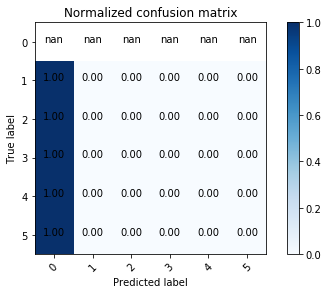

In [199]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix


prediction = list(user_prediction_round[test_data_matrix.nonzero()].flatten())
ground_truth = list(test_data_matrix[test_data_matrix.nonzero()].flatten())
cnf_matrix = confusion_matrix(ground_truth, prediction)

#cnf_matrix = cnf_matrix(test_data_matrix, user_prediction)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3','4','5'], normalize=True,
                      title='Normalized confusion matrix')